In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import qdatoolkit as qda

file_path = "data/stacked_data.csv"
df = pd.read_csv(file_path)

df.head()

t       x       y      z  layer_id  sensor0  sensor1    temp  \
0  80444000.0  26.048 -66.325  21.12       528    801.0    798.0  1591.9   
1  80444010.0  26.054 -66.332  21.12       528    803.0    798.0  1594.6   
2  80444020.0  26.061 -66.338  21.12       528    789.0    785.0  1593.3   
3  80444030.0  26.063 -66.342  21.12       528    785.0    790.0  1580.7   
4  80444040.0  26.066 -66.345  21.12       528    785.0    790.0  1580.7   

   track_id  track_orient  pos_rel  t_rel  
0         0           119  0.00000    0.0  
1         0           119  0.00816   10.0  
2         0           119  0.01633   20.0  
3         0           119  0.02449   30.0  
4         0           119  0.03265   40.0

In [3]:
# first create pivot table and then crop
def generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round=1):
    temperature_matrices = []
    for layer_id in layer_ids:
        layer_df = df[df['layer_id'] == layer_id]

        #layer_df['x_bin'] = layer_df['x'].round(digits_round)
        #layer_df['y_bin'] = layer_df['y'].round(digits_round)
        layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
        layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)

        # Create a pivot table with the grouped x and y values with mean
        temperature_matrix = layer_df.pivot_table(index='y_bin', columns='x_bin', values='temp', aggfunc='median')
        
        # Fill missing values with interpolation or a default value
        temperature_matrix = temperature_matrix.interpolate(axis=0).interpolate(axis=1)
        
        # Crop the temperature matrix based on the x_range and y_range
        cropped_matrix = temperature_matrix.loc[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        temperature_matrices.append(cropped_matrix.to_numpy())
    return np.array(temperature_matrices)

In [4]:
digits_round = 1
x_range = (26.264, 38.053)
y_range = (-66.506, -54.848)
layer_ids = [224, 225, 226, 227, 228, 324, 325, 326, 327, 328, 424, 425, 426, 427, 428, 524, 525, 526, 527, 528, 569, 570, 571, 572, 573]
list_25l = generate_temperature_matrices_v1(df,layer_ids, x_range, y_range, digits_round)

/var/folders/zb/w1kj5qrn31j0nl8g2bsgq6h40000gn/T/ipykernel_1585/437303520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
/var/folders/zb/w1kj5qrn31j0nl8g2bsgq6h40000gn/T/ipykernel_1585/437303520.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)


In [5]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming list_25l is a numpy array of shape (25, 120, 118)
num_layers = list_25l.shape[0]
height = list_25l.shape[1]
width = list_25l.shape[2]
smallest_cluster_pixels = []
biggest_cluster_pixels = []

for i in range(num_layers):
    # Extract the current layer
    current_layer = list_25l[i, :, :]

    # Standardize the data before reshaping for PCA
    scaler_pca = StandardScaler()
    current_layer_scaled = scaler_pca.fit_transform(current_layer)

    # Reshape the standardized data for PCA
    X = current_layer_scaled.reshape(-1, 1)

    # Apply PCA
    pca = PCA(n_components=1)
    scores = pca.fit_transform(X)

    # Compute Hotelling’s T² statistic for each pixel
    explained_variance = pca.explained_variance_
    if explained_variance[0] > 1e-8:
        T2 = (scores ** 2) / explained_variance[0]
    else:
        T2 = np.zeros_like(scores)

    # Standardize T2 values before K-means (optional but potentially useful)
    scaler_kmeans = StandardScaler()
    T2_scaled = scaler_kmeans.fit_transform(T2.reshape(-1, 1))

    # Apply K-means clustering on the T² map
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
    clusters_flat = kmeans.fit_predict(T2_scaled)
    clusters_map = clusters_flat.reshape(height, width)

    # Calculate the size of each cluster
    unique_clusters, counts = np.unique(clusters_map, return_counts=True)
    cluster_sizes = dict(zip(unique_clusters, counts))

    # Find the label of the smallest and biggest cluster
    smallest_cluster_label = min(cluster_sizes, key=cluster_sizes.get)
    biggest_cluster_label = max(cluster_sizes, key=cluster_sizes.get)

    # Extract the pixel coordinates and values for the smallest cluster
    smallest_cluster_indices = np.where(clusters_map == smallest_cluster_label)
    smallest_cluster_coords = list(zip(smallest_cluster_indices[0], smallest_cluster_indices[1]))
    smallest_cluster_values = current_layer_scaled[smallest_cluster_indices]
    smallest_cluster_pixels.append({
        "layer": i + 1,
        "cluster_label": smallest_cluster_label,
        "pixel_coordinates": smallest_cluster_coords,
        "pixel_values": smallest_cluster_values
    })

    # Extract the pixel coordinates and values for the biggest cluster
    biggest_cluster_indices = np.where(clusters_map == biggest_cluster_label)
    biggest_cluster_coords = list(zip(biggest_cluster_indices[0], biggest_cluster_indices[1]))
    biggest_cluster_values = current_layer_scaled[biggest_cluster_indices]
    biggest_cluster_pixels.append({
        "layer": i + 1,
        "cluster_label": biggest_cluster_label,
        "pixel_coordinates": biggest_cluster_coords,
        "pixel_values": biggest_cluster_values
    })

In [6]:
# Iterate through each layer's smallest cluster data
data = []
for layer_data in smallest_cluster_pixels:
    layer_id = layer_data['layer']
    pixel_coordinates = layer_data['pixel_coordinates']
    pixel_values = layer_data['pixel_values']
    
    # Add each pixel's data to the list
    for (y, x), temp_std in zip(pixel_coordinates, pixel_values):
        data.append({'x': x, 'y': y, 'temp_std': temp_std, 'layer_id': layer_id})

# Create a DataFrame from the list
high_T2_cluster = pd.DataFrame(data)
high_T2_cluster.head()

x  y  temp_std  layer_id
0  0  0  2.732935         1
1  2  0  2.486629         1
2  4  0  2.301647         1
3  6  0  3.156023         1
4  7  0  1.891568         1

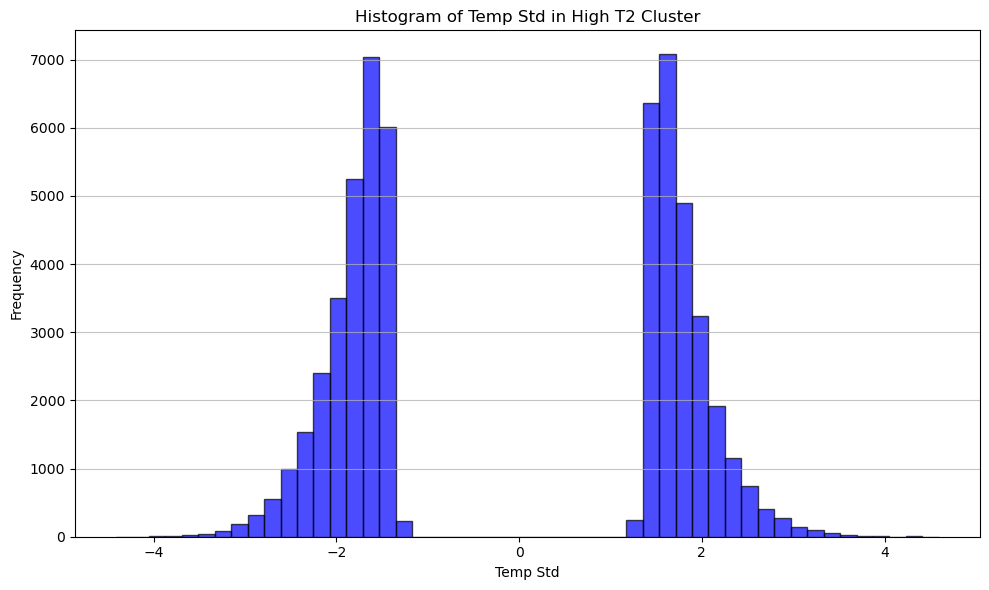

In [6]:
# Create a histogram of 'temp_std'
plt.figure(figsize=(10, 6))
plt.hist(high_T2_cluster['temp_std'], bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Temp Std')
plt.ylabel('Frequency')
plt.title('Histogram of Temp Std in High T2 Cluster')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

In [8]:
# Separate into cold_spots and hot_spots based on temp_std threshold
cold_spots = high_T2_cluster[high_T2_cluster['temp_std'] < 0].copy()
hot_spots = high_T2_cluster[high_T2_cluster['temp_std'] >= 0].copy()

# Reset indices for both DataFrames
cold_spots.reset_index(drop=True, inplace=True)
hot_spots.reset_index(drop=True, inplace=True)


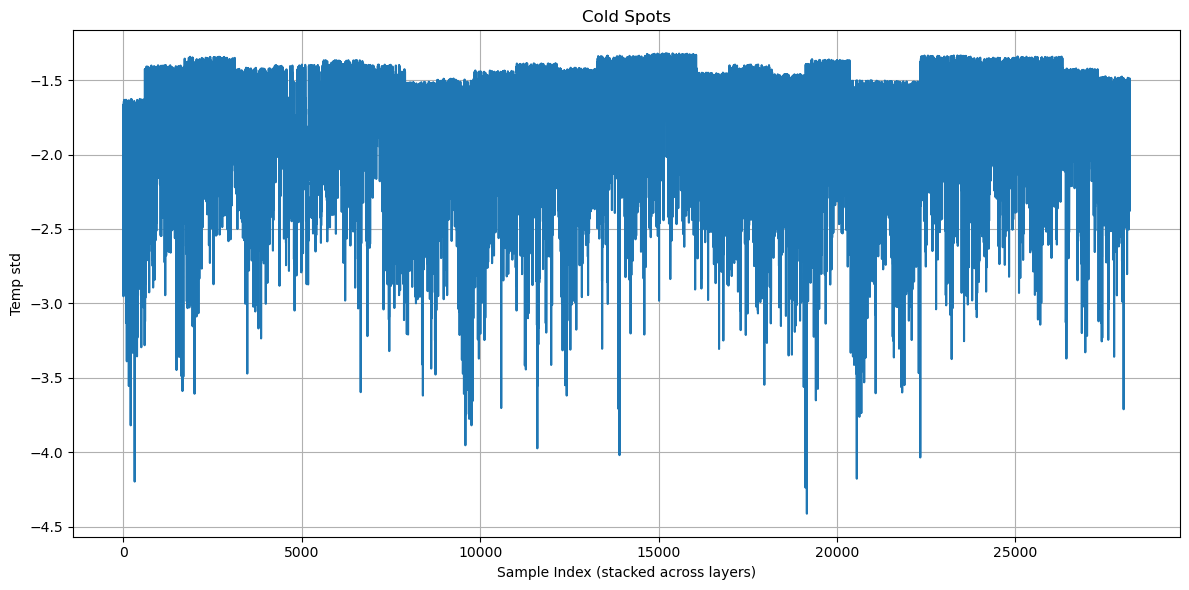

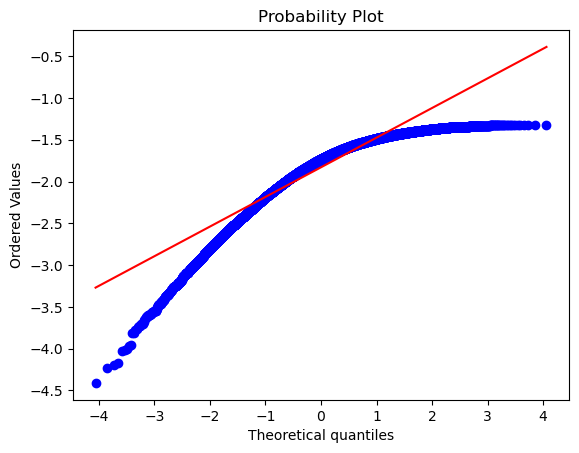

/opt/anaconda3/envs/qda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.897
Shapiro-wilk test p-value = 0.000
Runs test statistic = -36.415
Runs test p-value = 0.000



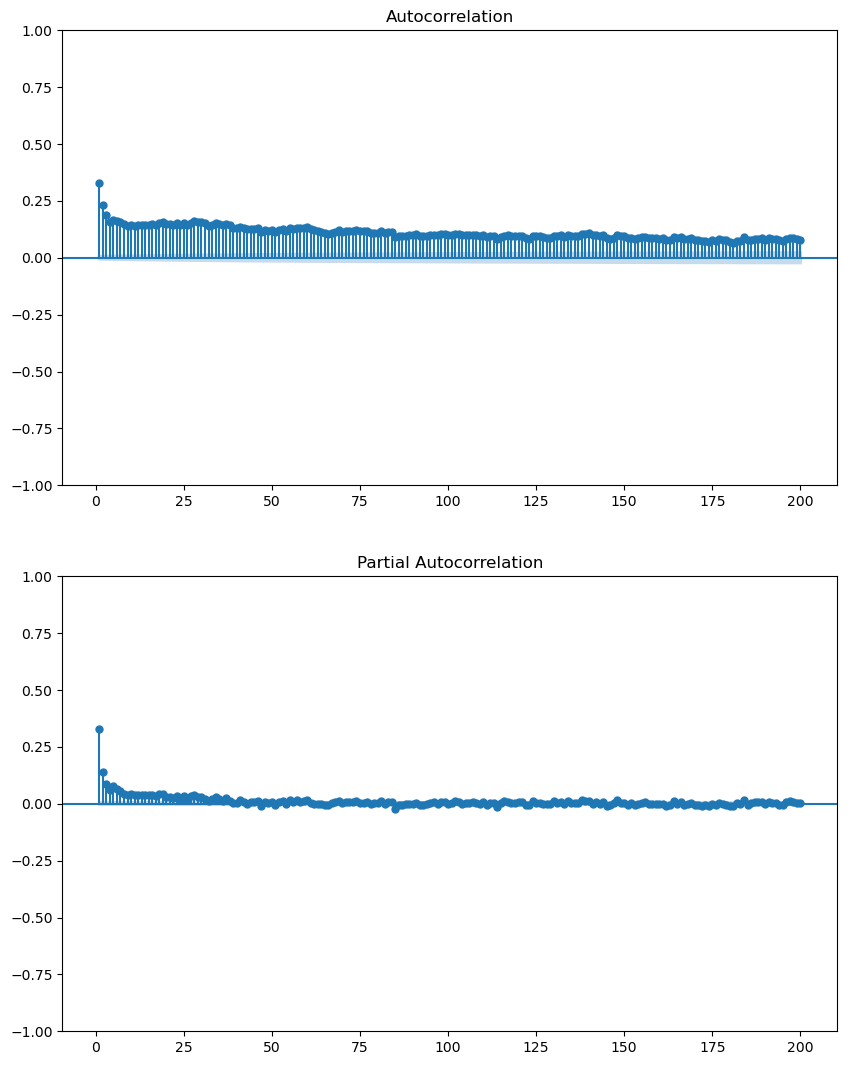

In [9]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(cold_spots['temp_std'], label='Temp std')
plt.xlabel('Sample Index (stacked across layers)')
plt.ylabel('Temp std')
plt.title('Cold Spots')
plt.grid(True)
plt.tight_layout()
plt.show()

_ = qda.Assumptions(cold_spots['temp_std']).normality()  # Controllo di normalità
_ = qda.Assumptions(cold_spots['temp_std']).independence()  # Controllo di indipendenza

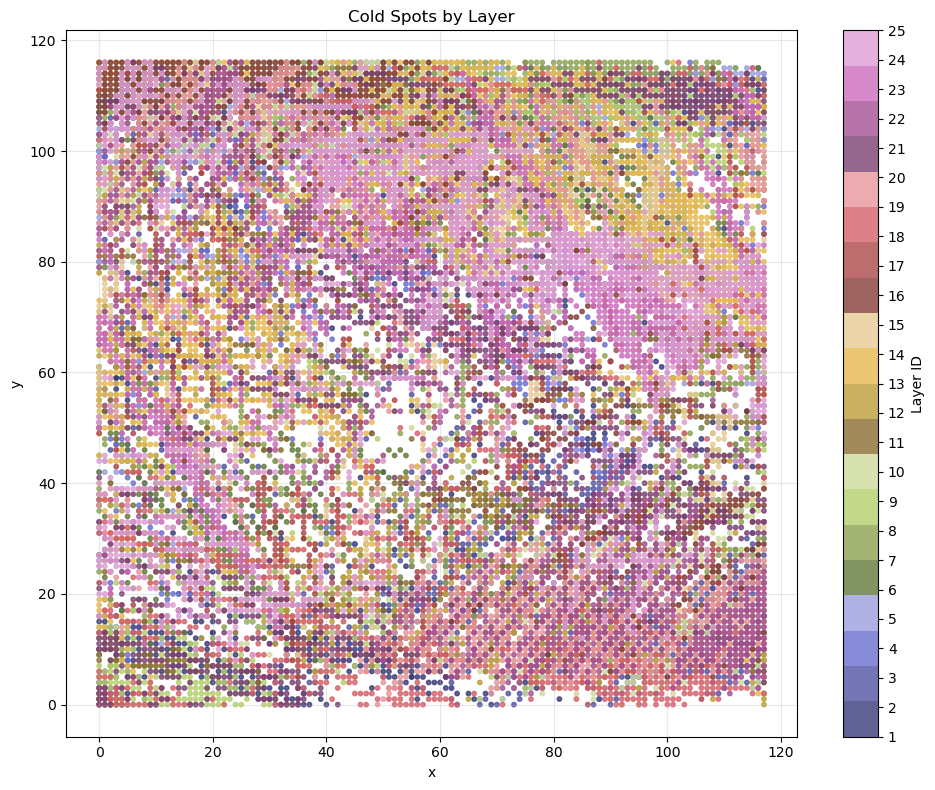

In [9]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    cold_spots['x'], cold_spots['y'],
    c=cold_spots['layer_id'], cmap='tab20b', s=10, alpha=0.8
)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Cold Spots by Layer')
cbar = plt.colorbar(scatter, ticks=range(1, 26))
cbar.set_label('Layer ID')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

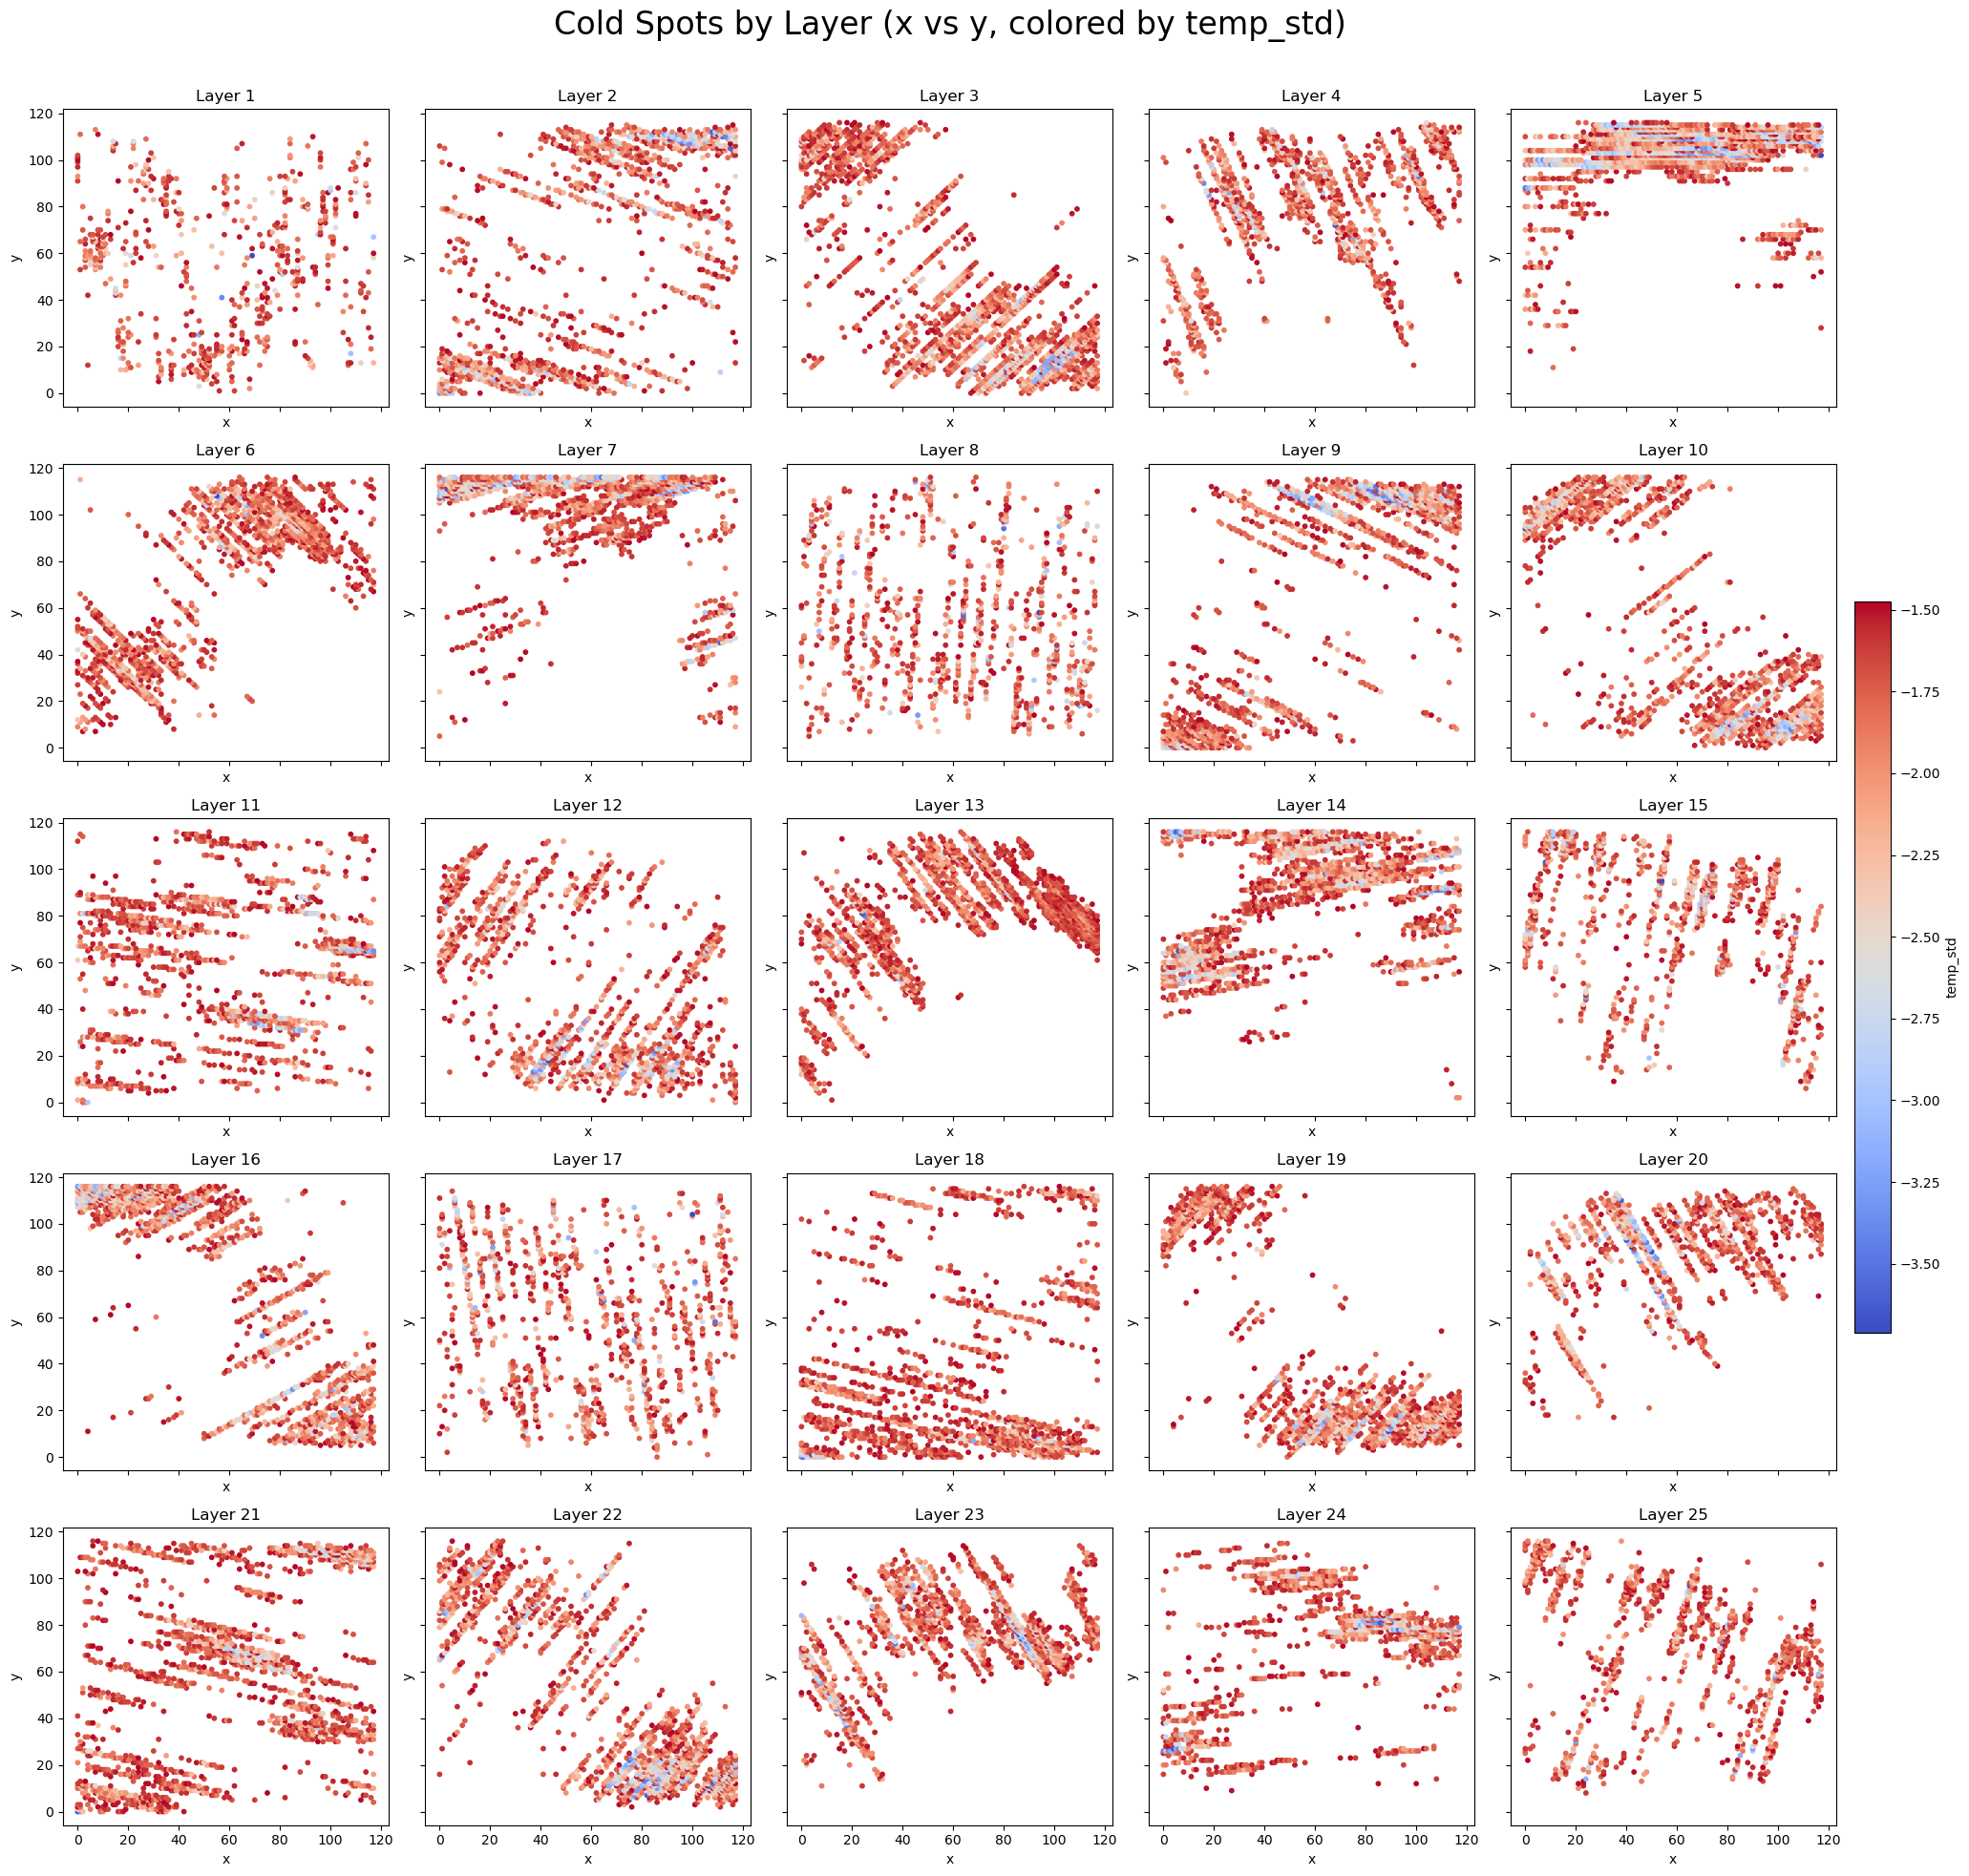

In [10]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20), sharex=True, sharey=True)
axes = axes.flatten()

for idx, layer_id in enumerate(sorted(cold_spots['layer_id'].unique())):
    ax = axes[idx]
    layer_data = cold_spots[cold_spots['layer_id'] == layer_id]
    sc = ax.scatter(layer_data['x'], layer_data['y'], c=layer_data['temp_std'], cmap='coolwarm', s=10)
    ax.set_title(f'Layer {layer_id}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

fig.suptitle('Cold Spots by Layer (x vs y, colored by temp_std)', fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.01, label='temp_std')
plt.show()

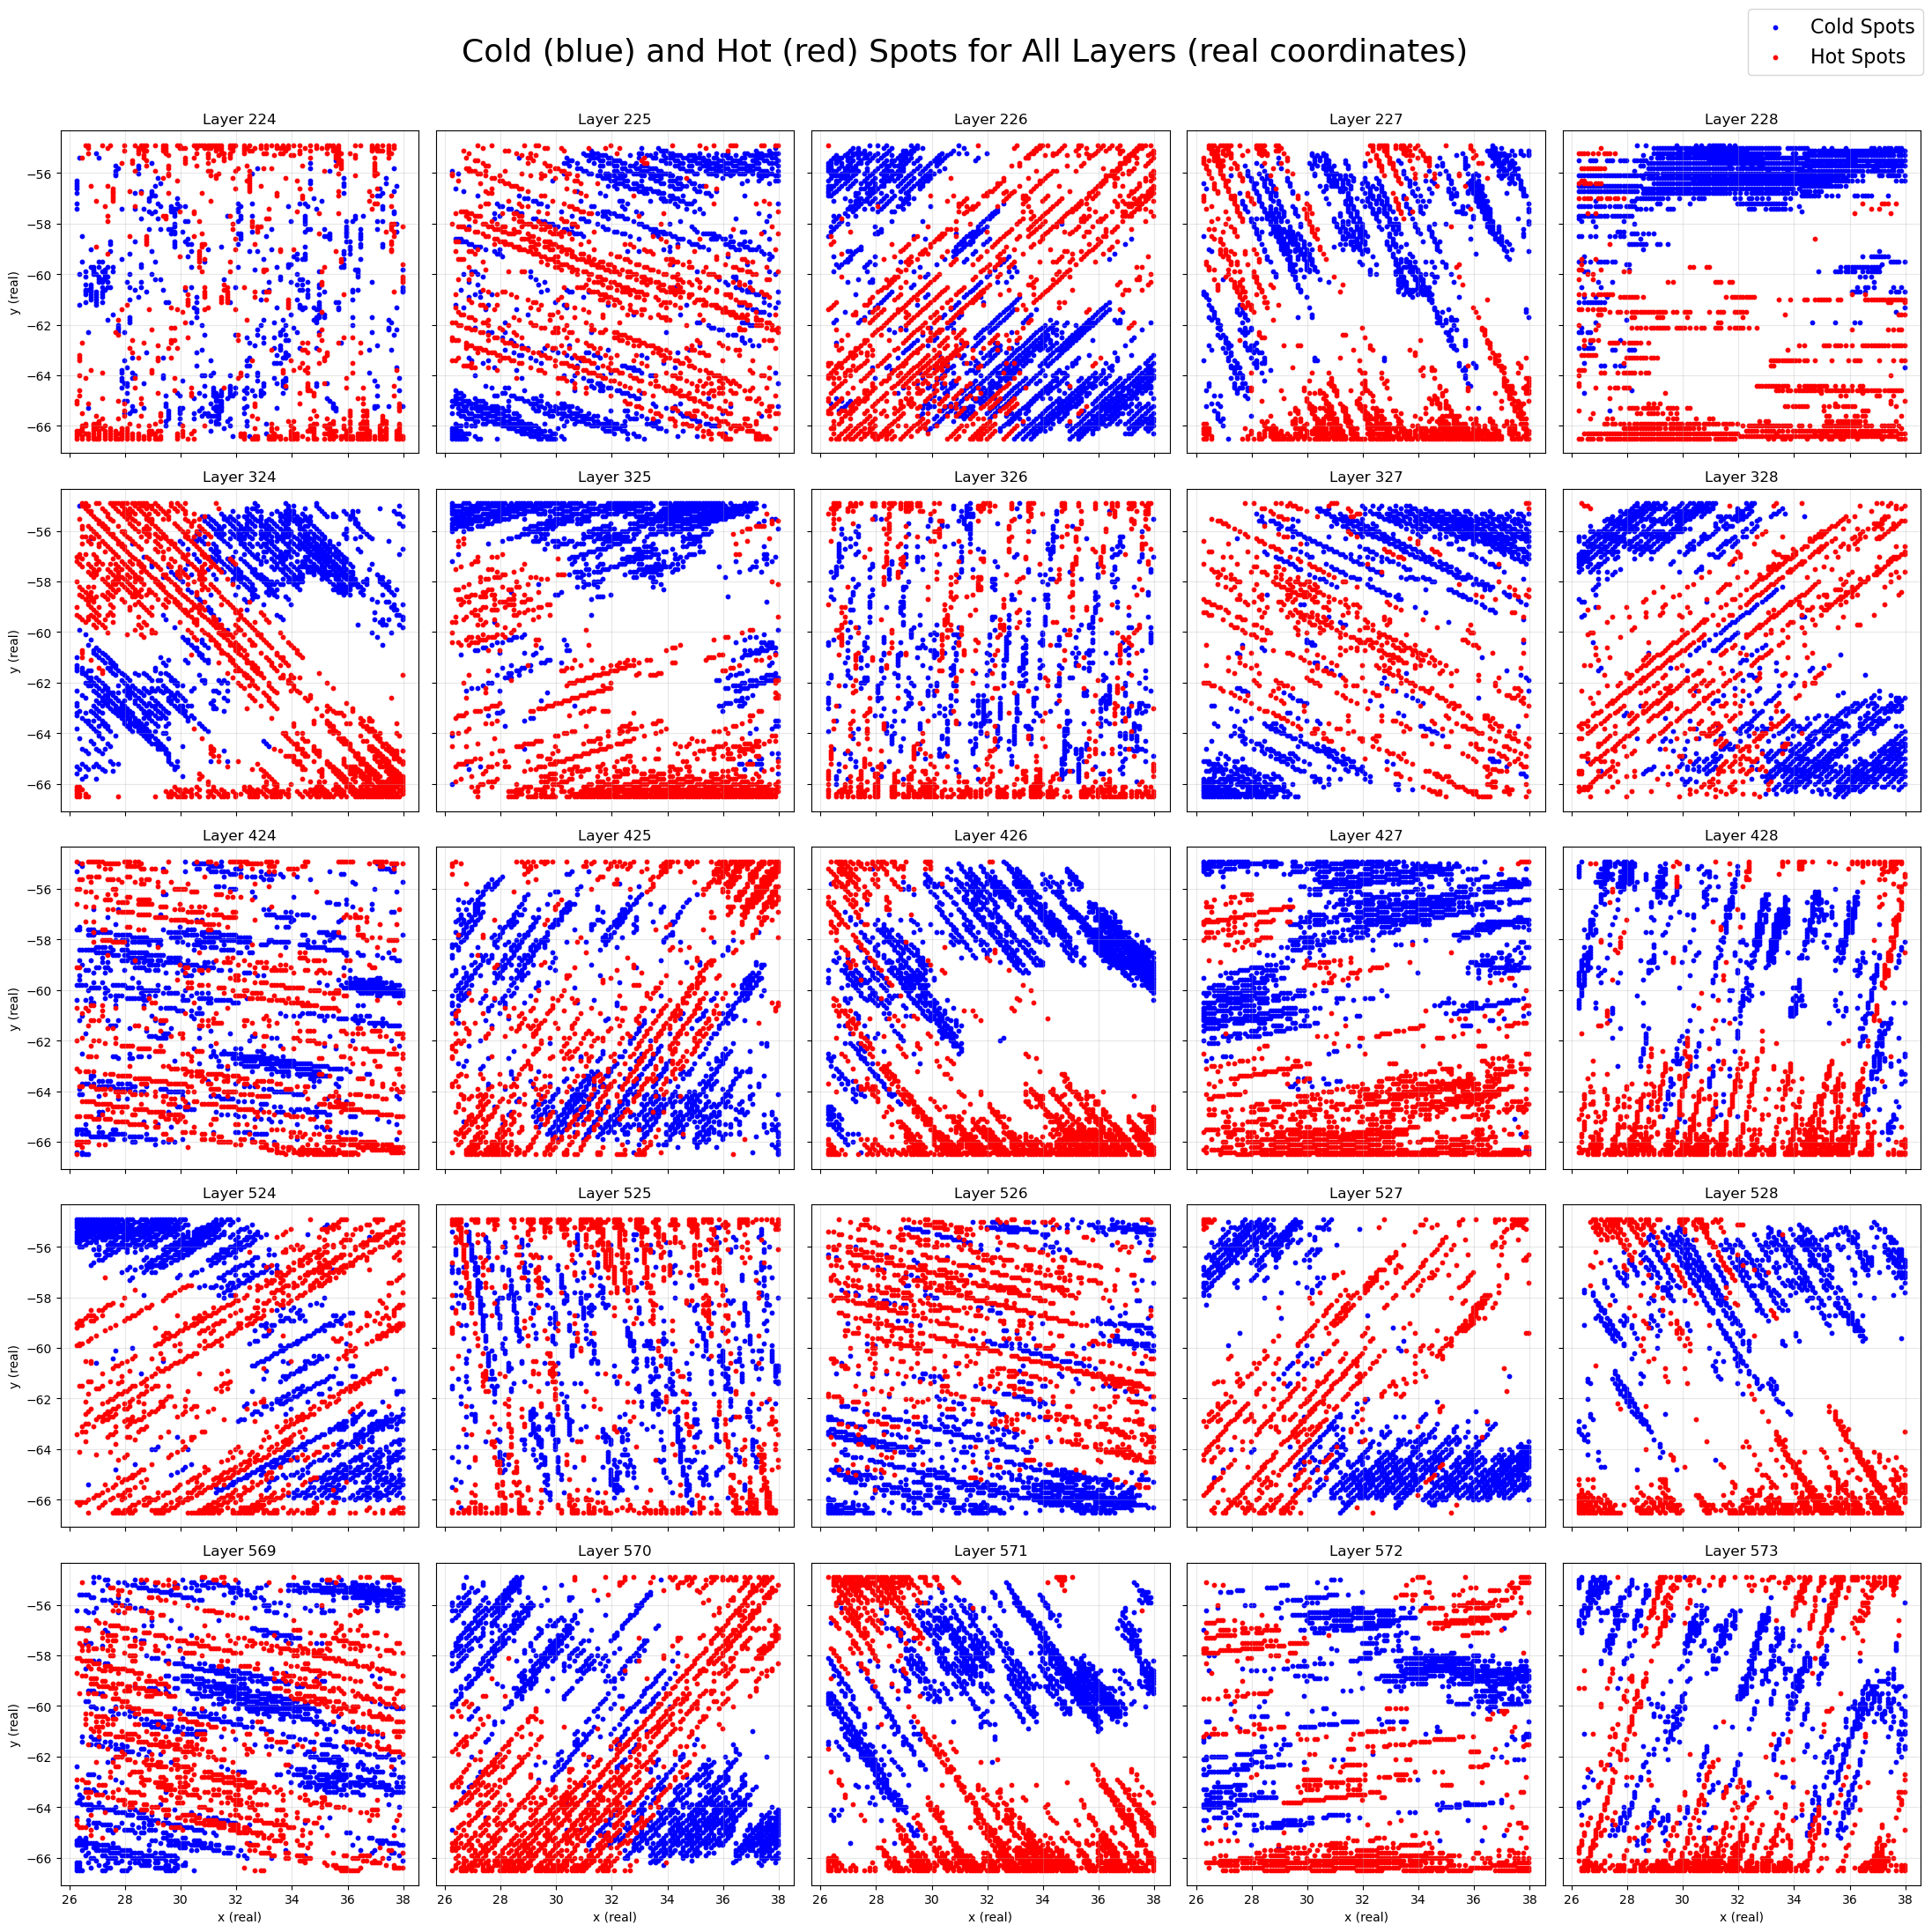

In [11]:
fig, axes = plt.subplots(5, 5, figsize=(22, 22), sharex=True, sharey=True)
axes = axes.flatten()

for idx, lid in enumerate(sorted(layer_ids)):
    # Layer index in cold_spots/hot_spots is 1-based (1 for 224, 2 for 225, ...)
    cold = cold_spots[cold_spots['layer_id'] == idx + 1].copy()
    hot = hot_spots[hot_spots['layer_id'] == idx + 1].copy()
    # Map grid indices to real coordinates
    cold['x_real'] = x_range[0] + cold['x'] * 10**-digits_round
    cold['y_real'] = y_range[0] + cold['y'] * 10**-digits_round
    hot['x_real'] = x_range[0] + hot['x'] * 10**-digits_round
    hot['y_real'] = y_range[0] + hot['y'] * 10**-digits_round

    ax = axes[idx]
    ax.scatter(cold['x_real'], cold['y_real'], color='blue', s=10, label='Cold Spots')
    ax.scatter(hot['x_real'], hot['y_real'], color='red', s=10, label='Hot Spots')
    ax.set_title(f'Layer {lid}')
    ax.grid(True, alpha=0.3)
    if idx % 5 == 0:
        ax.set_ylabel('y (real)')
    if idx >= 20:
        ax.set_xlabel('x (real)')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=16)
fig.suptitle('Cold (blue) and Hot (red) Spots for All Layers (real coordinates)', fontsize=26)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### questo metodo è errato

In [12]:
from scipy.spatial.distance import cdist

# Seleziona i punti cold e hot del layer 224 (layer_id == 1)
cold_224 = cold_spots[cold_spots['layer_id'] == 1][['x', 'y']].to_numpy()
hot_224 = hot_spots[hot_spots['layer_id'] == 1][['x', 'y']].to_numpy()

# Calcola la matrice delle distanze tra tutti i punti hot e cold
dist_matrix = cdist(hot_224, cold_224, metric='euclidean')

# Trova la distanza minima per ogni punto hot rispetto ai punti cold
min_dist_hot_to_cold = dist_matrix.min(axis=1)

# Soglia per "vicino" (puoi modificarla in base ai dati, qui si usa la mediana)
threshold = np.median(min_dist_hot_to_cold)

# Assegna "alto" se la distanza minima è sotto la soglia, "basso" altrimenti
proximity_labels = np.where(min_dist_hot_to_cold <= threshold, 'alto', 'basso')

# Crea un DataFrame con i risultati
hot_224_results = pd.DataFrame(hot_224, columns=['x', 'y'])
hot_224_results['min_dist_to_cold'] = min_dist_hot_to_cold
hot_224_results['vicinanza'] = proximity_labels

# Crea un indicatore numerico inversamente proporzionale alla distanza (es: 1/distanza, normalizzato tra 0 e 1)
# Per evitare divisione per zero, aggiungi una piccola costante epsilon
epsilon = 1e-6
inv_dist = 1 / (min_dist_hot_to_cold + epsilon)
# Normalizza tra 0 e 1
inv_dist_norm = (inv_dist - inv_dist.min()) / (inv_dist.max() - inv_dist.min())
hot_224_results['vicinanza_num'] = inv_dist_norm

hot_224_results.head()

x  y  min_dist_to_cold vicinanza  vicinanza_num
0  0  0         12.649111     basso       0.031212
1  2  0         12.165525     basso       0.034518
2  4  0         12.000000     basso       0.035711
3  6  0         12.165525     basso       0.034518
4  7  0         12.369317     basso       0.033093

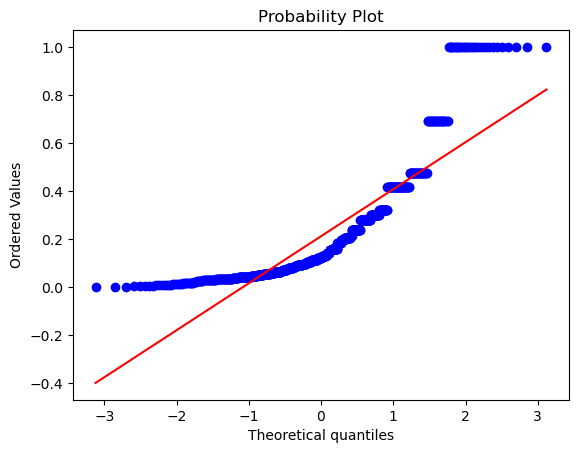

Shapiro-wilk test statistic = 0.760
Shapiro-wilk test p-value = 0.000
Runs test statistic = -14.965
Runs test p-value = 0.000



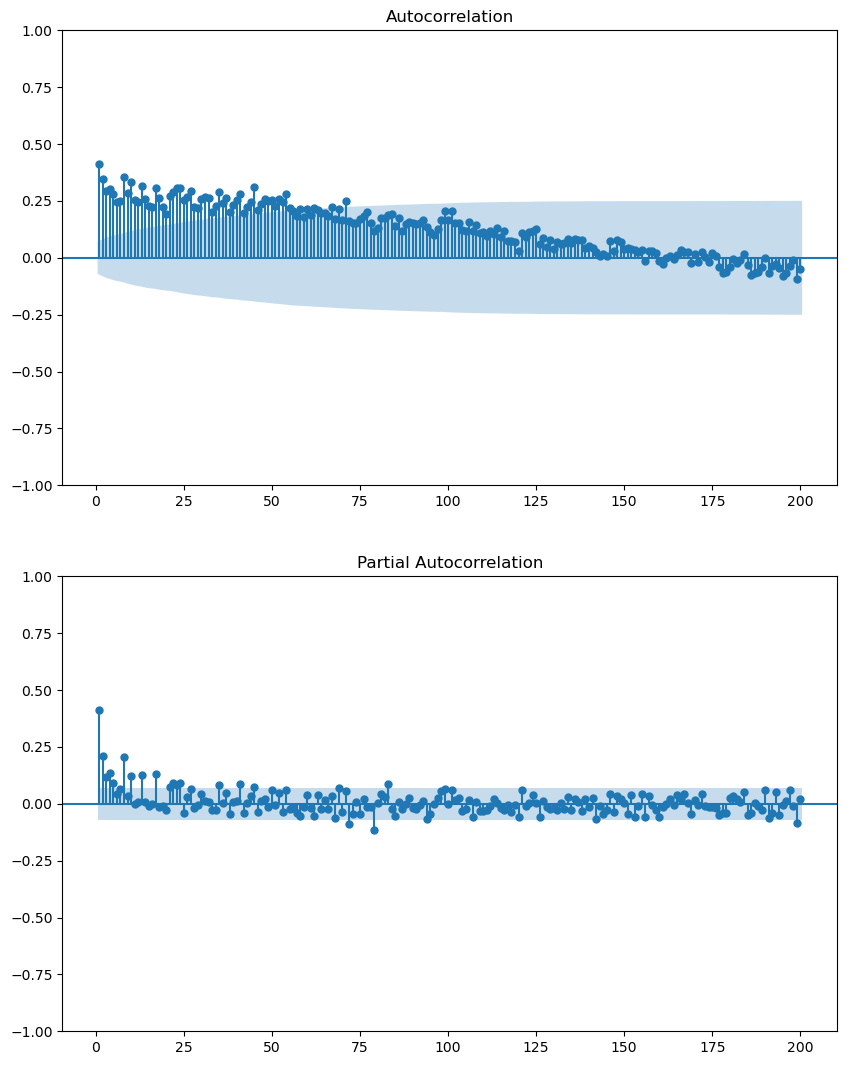

In [13]:
_=qda.Assumptions(hot_224_results['vicinanza_num']).normality()  # Controllo di normalità
_=qda.Assumptions(hot_224_results['vicinanza_num']).independence()  # Controllo di indipendenza

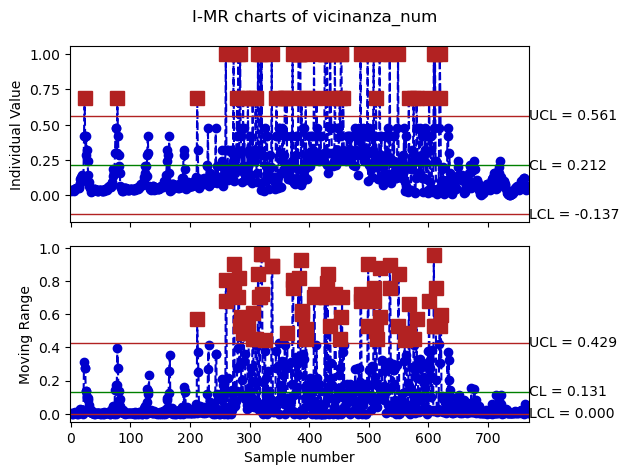

In [14]:
# DataFrame for the residuals
df_SCC = pd.DataFrame(hot_224_results, columns=['vicinanza_num'])

# I-MR control chart
df_SCC_IMR = qda.ControlCharts.IMR(df_SCC, 'vicinanza_num')

### Da qui metodo che torna 

In [17]:
# Suddividi x e y in 5 intervalli ciascuno (5x5=25 aree) con lo stesso numero di punti per area
x_area_cs, x_bins_cs = pd.qcut(cold_spots['x'], q=10, labels=False, retbins=True, duplicates='drop')
y_area_cs, y_bins_cs = pd.qcut(cold_spots['y'], q=10, labels=False, retbins=True, duplicates='drop')

# Calcola area_id (1-25) secondo la posizione nella griglia 5x5
cold_spots['area_id'] = (y_area_cs * 10 + x_area_cs + 1).astype(int)

# Suddividi x e y in 5 intervalli ciascuno (5x5=25 aree) con lo stesso numero di punti per area
x_area_hs = pd.cut(hot_spots['x'], bins=x_bins_cs, labels=False, include_lowest=True)
y_area_hs = pd.cut(hot_spots['y'], bins=y_bins_cs, labels=False, include_lowest=True)
hot_spots['area_id'] = (y_area_hs * 10 + x_area_hs + 1).astype(int)



In [18]:
# Conta il numero di punti per ogni area_id in cold_spots e hot_spots
cold_counts_per_area = cold_spots['area_id'].value_counts().sort_index()
hot_counts_per_area = hot_spots['area_id'].value_counts().sort_index()

# Unisci in un DataFrame per confronto
area_counts = pd.DataFrame({
    'cold_count': cold_counts_per_area,
    'hot_count': hot_counts_per_area
}).fillna(0).astype(int)

area_counts

cold_count  hot_count
1           377        750
2           238        762
3           258        950
4           228        939
5           280        904
..          ...        ...
96          202        119
97          198        162
98          195        156
99          186        162
100         170        293

[100 rows x 2 columns]

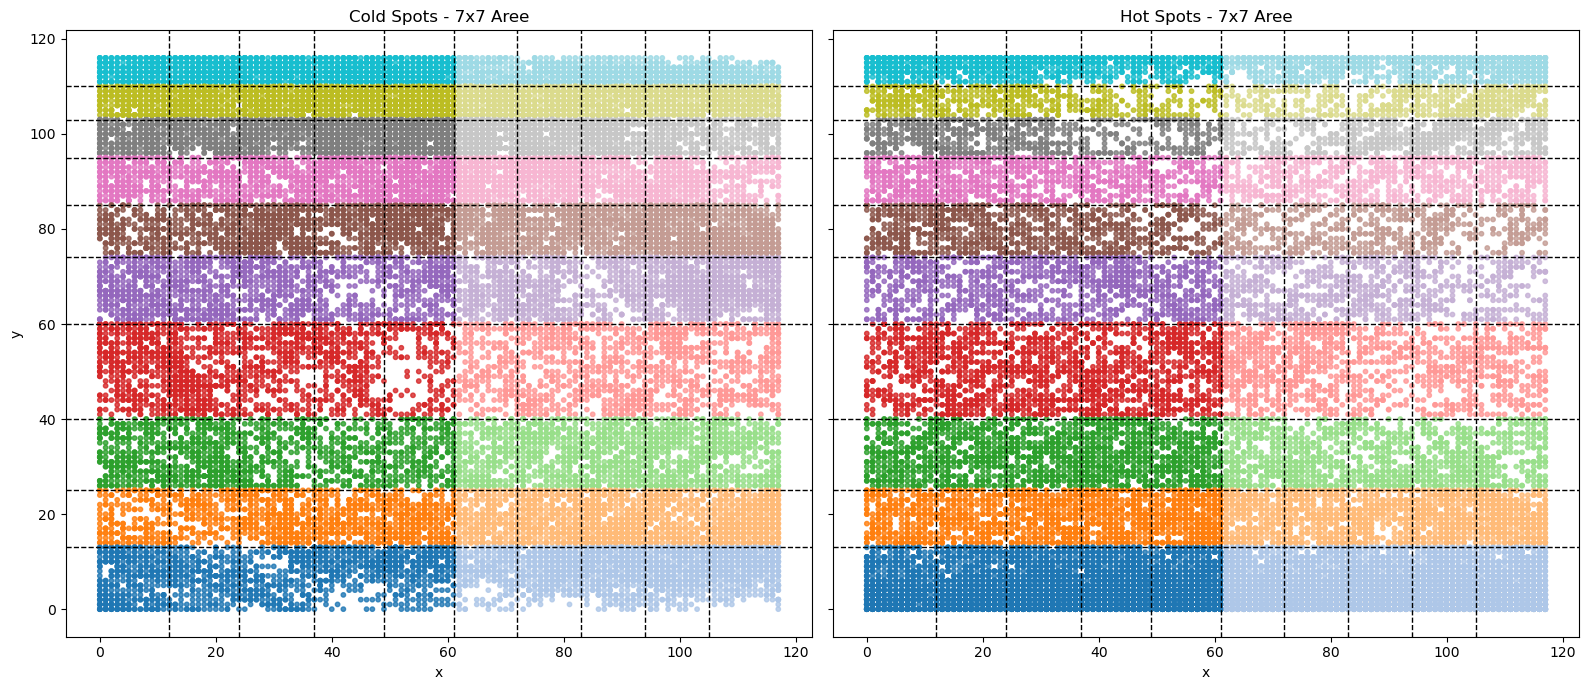

In [171]:
# Plot delle aree per cold_spots e hot_spots (7x7 aree)

fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)

# Cold spots
axes[0].scatter(
    cold_spots['x'], cold_spots['y'],
    c=cold_spots['area_id'], cmap='tab20', s=10, alpha=0.8
)
axes[0].set_title('Cold Spots - 7x7 Aree')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
for xb in x_bins_cs[1:-1]:
    axes[0].axvline(x=xb, color='k', linestyle='--', linewidth=1)
for yb in y_bins_cs[1:-1]:
    axes[0].axhline(y=yb, color='k', linestyle='--', linewidth=1)

# Hot spots
axes[1].scatter(
    hot_spots['x'], hot_spots['y'],
    c=hot_spots['area_id'], cmap='tab20', s=10, alpha=0.8
)
axes[1].set_title('Hot Spots - 7x7 Aree')
axes[1].set_xlabel('x')
for xb in x_bins_cs[1:-1]:
    axes[1].axvline(x=xb, color='k', linestyle='--', linewidth=1)
for yb in y_bins_cs[1:-1]:
    axes[1].axhline(y=yb, color='k', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

In [ ]:
# Media dei punti cold per ogni area e layer
mean_cold_per_area_layer = cold_spots.groupby(['area_id', 'layer_id'])['temp_std'].mean().unstack()

# Media dei punti hot per ogni area e layer
mean_hot_per_area_layer = hot_spots.groupby(['area_id', 'layer_id'])['temp_std'].mean().unstack()

print("Media cold per area e layer:")
print(mean_cold_per_area_layer)
print("Media hot per area e layer:")
print(mean_hot_per_area_layer)

# Calcola la differenza tra le medie hot e cold per ogni area_id e layer_id
diff_hot_cold_per_area_layer = mean_hot_per_area_layer - (- mean_cold_per_area_layer)
print("Differenza hot-cold per area e layer:")
print(diff_hot_cold_per_area_layer)

Media cold per area e layer:
layer_id        1         2         3         4         5         6   \
area_id                                                                
1        -1.776948 -1.949563 -1.732029 -1.785528 -1.656674 -1.691475   
2        -2.234156 -2.070980       NaN -1.710288       NaN -1.449210   
3        -1.969032 -1.958546 -1.705947       NaN       NaN -1.455630   
4        -2.067841 -1.849163 -1.770814       NaN       NaN -1.453546   
5        -2.000201 -1.796569 -1.722514       NaN       NaN       NaN   
...            ...       ...       ...       ...       ...       ...   
96             NaN -1.689538       NaN       NaN -1.855822 -1.660549   
97             NaN -1.958346       NaN       NaN -1.774505 -1.622326   
98             NaN -2.225805       NaN -1.509399 -1.858976 -1.636402   
99             NaN -1.944647       NaN -2.031617 -1.952522 -1.548249   
100            NaN -2.250773       NaN -1.824742 -1.852597 -1.512658   

layer_id        7         8       

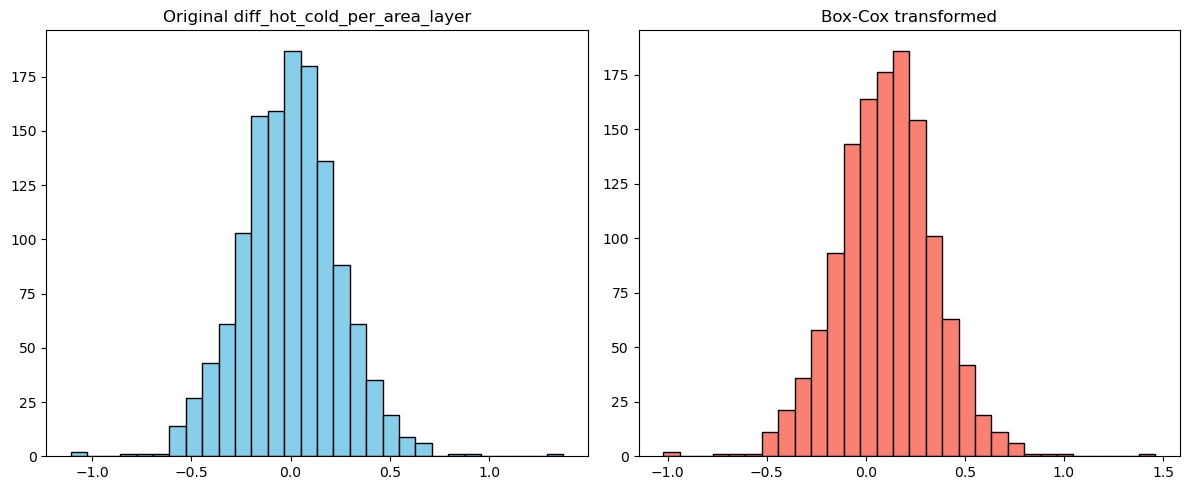

/opt/anaconda3/envs/qda/lib/python3.9/site-packages/qdatoolkit/models.py:731: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


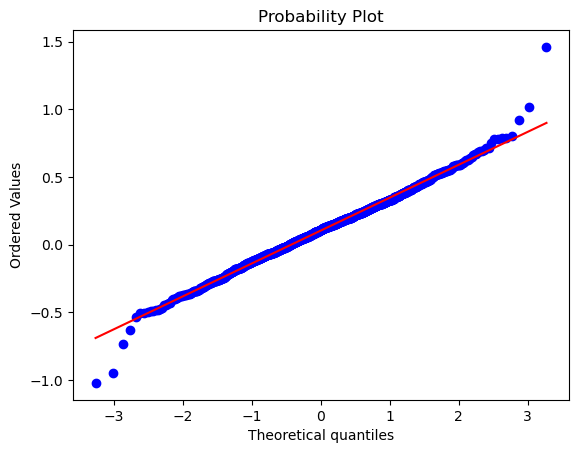

Shapiro-wilk test statistic = 0.992
Shapiro-wilk test p-value = 0.000


In [173]:
from scipy.stats import boxcox

# Appiattisci i valori in una serie 1D, ignorando eventuali NaN
diff_values = diff_hot_cold_per_area_layer.values.flatten()
diff_values = diff_values[~np.isnan(diff_values)]

# Box-Cox richiede valori > 0, quindi shift se necessario
min_val = diff_values.min()
if min_val <= 0:
    shift = abs(min_val) + 1e-6
else:
    shift = 0

diff_shifted = diff_values + shift
diff_boxcox, fitted_lambda = boxcox(diff_shifted)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(diff_values, bins=30, color='skyblue', edgecolor='k')
plt.title('Original diff_hot_cold_per_area_layer')
plt.subplot(1,2,2)
plt.hist(diff_boxcox, bins=30, color='salmon', edgecolor='k')
plt.title('Box-Cox transformed')
plt.tight_layout()
plt.show()

_ = qda.Assumptions(diff_boxcox).normality()  

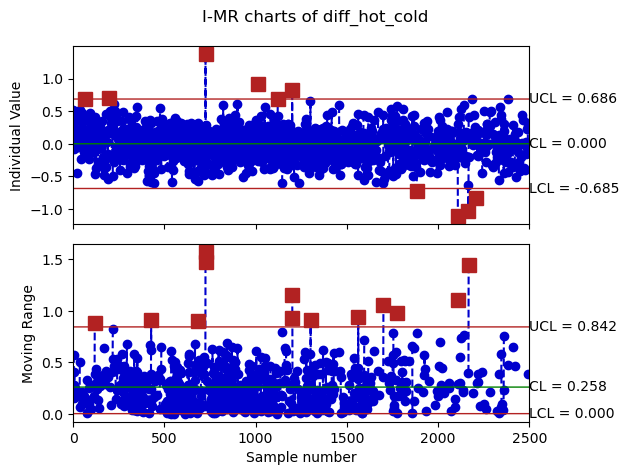

In [174]:
# diff_hot_cold_per_area_layer è una DataFrame (area_id x layer_id) con le differenze hot-cold le differenze hot-cold le differenze hot-
# Per la carta I-MR, serve una serie "long" di valori

diff_hot_cold_values = diff_hot_cold_per_area_layer.values.flatten()


df_diff_hot_cold_long = pd.DataFrame(diff_hot_cold_values, columns=['diff_hot_cold'])
_ = qda.ControlCharts.IMR(df_diff_hot_cold_long, 'diff_hot_cold')

In [175]:
import numpy as np

# Appiattisci la matrice e salva anche la posizione flat originale
flat_values = diff_hot_cold_per_area_layer.values.flatten()
# Trova gli indici dei valori non NaN
not_nan_mask = ~np.isnan(flat_values)
not_nan_values = flat_values[not_nan_mask]
not_nan_indices = np.where(not_nan_mask)[0]

# Calcola i limiti della carta I-MR solo sui valori non NaN
mean = np.mean(not_nan_values)
mr = np.mean(np.abs(np.diff(not_nan_values)))
d2 = 1.128  # per n=2
UCL = mean + 3 * (mr / d2)
LCL = mean - 3 * (mr / d2)

# Trova gli indici OOC rispetto all'array filtrato
ooc_mask = (not_nan_values > UCL) | (not_nan_values < LCL)
ooc_flat_indices = not_nan_indices[ooc_mask]

# Recupera area_id e layer_id per ogni valore OOC
n_areas, n_layers = diff_hot_cold_per_area_layer.shape
area_ids = diff_hot_cold_per_area_layer.index.values
layer_ids = diff_hot_cold_per_area_layer.columns.values

for idx in ooc_flat_indices:
    area_idx, layer_idx = np.unravel_index(idx, (n_areas, n_layers))
    area_id = area_ids[area_idx]
    layer_id = layer_ids[layer_idx]
    value = diff_hot_cold_per_area_layer.iloc[area_idx, layer_idx]
    print(f"Valore fuori controllo: {value:.3f} (area_id={area_id}, layer_id={layer_id})")

Valore fuori controllo: 1.371 (area_id=30, layer_id=1)
Valore fuori controllo: 0.921 (area_id=41, layer_id=15)
Valore fuori controllo: 0.824 (area_id=49, layer_id=1)
Valore fuori controllo: -0.730 (area_id=76, layer_id=9)
Valore fuori controllo: -1.106 (area_id=85, layer_id=9)
Valore fuori controllo: -1.036 (area_id=87, layer_id=17)
Valore fuori controllo: -0.833 (area_id=89, layer_id=7)


In [176]:
# Conta il numero di punti non NaN nel DataFrame diff_hot_cold_per_area_layer
num_non_nan = diff_hot_cold_per_area_layer.count().sum()
print(f"Numero di punti diversi da NaN in diff_hot_cold_per_area_layer: {num_non_nan}")

Numero di punti diversi da NaN in diff_hot_cold_per_area_layer: 1293


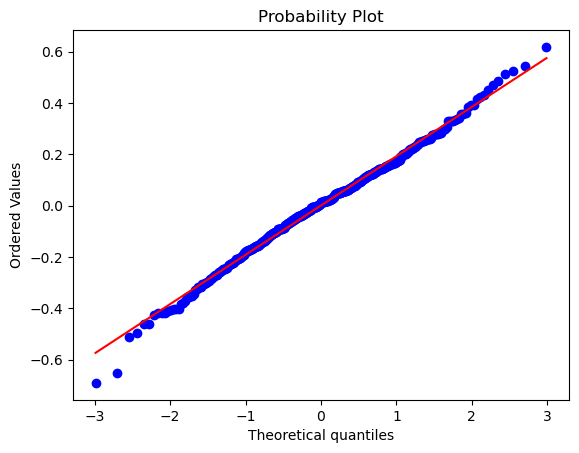

Shapiro-wilk test statistic = 0.995
Shapiro-wilk test p-value = 0.133
Runs test statistic = 0.432
Runs test p-value = 0.666



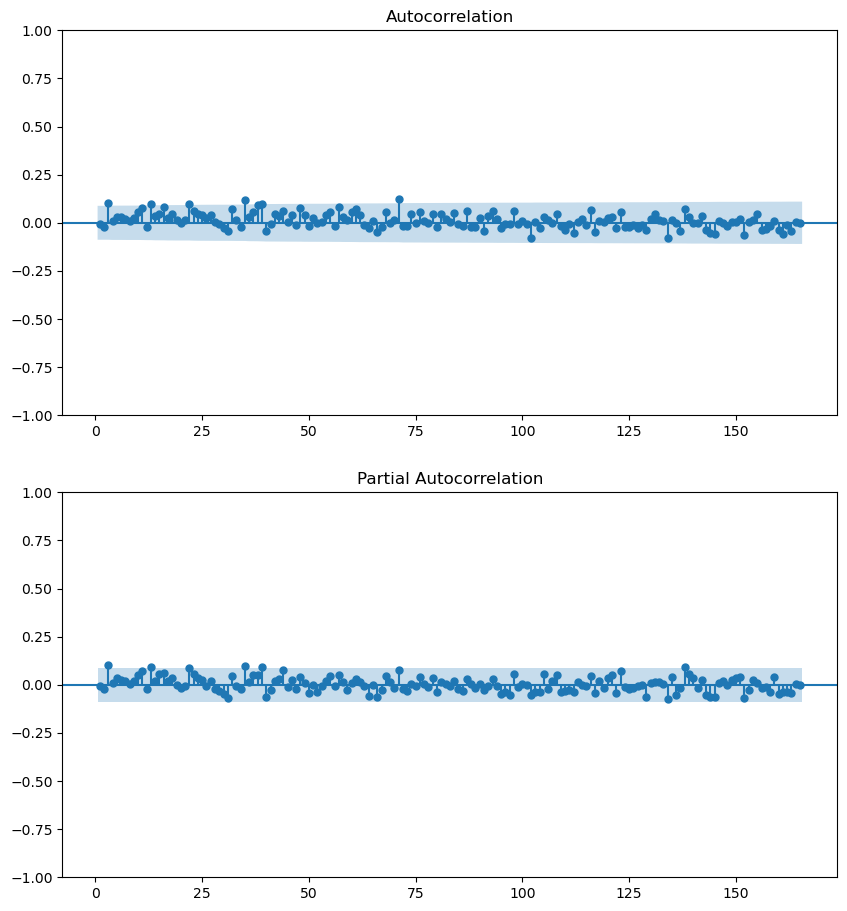

In [166]:
_=qda.Assumptions(df_diff_hot_cold_long['diff_hot_cold']).normality()  # Controllo di normalità   
_=qda.Assumptions(df_diff_hot_cold_long['diff_hot_cold']).independence()  # Controllo di indipendenza